## Text classification with pre-trained word embeddings

In [3]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-200')     # GLoVE vectors trained on Twitter with dimension 200

[==================================================] 100.0% 758.5/758.5MB downloaded


In [4]:
# underlying data / weights
glove_vectors.vectors.shape         # (num_of_words / vocab_size, embedding_dim)

(1193514, 200)

In [5]:
vocab = list(glove_vectors.vocab.keys())
vocab[:10]

['<user>',
 '.',
 ':',
 'rt',
 ',',
 '<repeat>',
 '<hashtag>',
 '<number>',
 '<url>',
 '!']

In [6]:
np.all(glove_vectors.word_vec('<user>') == glove_vectors.vectors[0])

True

In [7]:
glove_vectors['hello'].shape

(200,)

Download IMDB Movies reviews dataset. 

- Total: 50,000 samples
- Train set: 25,000 samples, with 12,500 positive samples and 12,500 negative samples
- Test set: same as train set

In [8]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz   # download
!tar -xf aclImdb_v1.tar.gz                                              # unzip / untar

--2022-02-10 06:33:38--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  33.4MB/s    in 2.4s    

2022-02-10 06:33:41 (33.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Load the data into a DataFrame. You don't need to worry too much about this

In [9]:
import os

def load_samples(dir):
    files = os.listdir(dir)
    samples = []
    for file in files:
        with open(os.path.join(dir, file)) as f:
            sample = ''.join(f.readlines())
            samples.append(sample)
    return samples

train_pos_samples = load_samples('aclImdb/train/pos')
train_neg_samples = load_samples('aclImdb/train/neg')
val_pos_samples = load_samples('aclImdb/test/pos')
val_neg_samples = load_samples('aclImdb/test/neg')

train_samples = [(x, 1) for x in train_pos_samples] + [(x, 0) for x in train_neg_samples]
val_samples = [(x, 1) for x in val_pos_samples] + [(x, 0) for x in val_neg_samples]

print("train size:", len(train_samples))
print('val size:', len(val_samples))

train size: 25000
val size: 25000


In [10]:
import pandas as pd

df_train = pd.DataFrame(train_samples, columns=['text', 'label'])
df_val = pd.DataFrame(val_samples, columns=['text', 'label'])

df_train

,text,label
0,I picked this one up on a whim from the librar...,1
1,A year after losing gorgeous Jane Parker (Maur...,1
2,Thre isn't a single Scorsese movie I'd place o...,1
3,Before watching this film I had heard a lot ab...,1
4,i'm not even sure what to say about this film....,1
...,...,...
24995,"We had to go to an appointment, so we turned o...",0
24996,Ever heard of a taiwanese horror movie? Or any...,0
24997,So what's the big fuss out of making an INDIAN...,0
24998,hello boys and girls... this isn't your regula...,0


In [11]:
from IPython.display import HTML, display

def set_css():
  display(HTML('<style>pre {white-space: pre-wrap;}</style>'))
get_ipython().events.register('pre_run_cell', set_css)              # wrap text in Google Colab

In [12]:
df_train.sample(10)

,text,label
7061,"A brilliant movie about family, guilt, sacrifi...",1
20374,I opted to see the film at the recent Dubai Fi...,0
8950,I had no idea what this movie was until I read...,1
4453,I was a fan of the book ever since third grade...,1
22153,There is absolutely nothing to redeem this mov...,0
1765,"Gandhi, the Great :<br /><br />Greatness in th...",1
23961,Kareena Kapoor in a bikini hmmmmmmmm.<br /><br...,0
4068,I only know of one other movie that could poss...,1
8810,Simon's best comedy is superbly crafted by dir...,1
18722,Was this the greatest movie that I have ever s...,0


In [13]:
sample = df_train.sample(1).iloc[0]     # pick the first row from a dataframe of 1 row
print(sample[0])        # text
print(sample[1])        # label

Acting was weak, but in a horror flick, I can live with that if the story is good. It wasn't. The initial event was an clumsy and obvious ploy to exploit most people's adoration of kids. OK, fine. Fast forward to the "place in the country" where they will recover emotionally. I like the revelation of the ghosts. OK, cool--this will be a supernatural kinda horror story, with rotting things partly in our world partly in...where ever. Then the action starts pulling like a three headed dog in a flurry of cats and birds--Is there an evil force trying to attack them directly? Is there an evil force trying to attack them INdirectly--make people do awful things they wouldn't really do? Oh, wait, no, maybe the whole REGION is some kind of psychic echo chamber where ambient discord can reverberate into murder? OK, hold on--maybe it's really just one little mentally tangled "Delbert"-style redneck boy who misses his Mommy and is on some kind of spree like a K-Tel Norman Bates knock off? Oh, yeah-

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))      # make it a set for fast lookup O(1)
list(en_stopwords)[:10]

['these',
 'here',
 'herself',
 'a',
 "you've",
 'to',
 'before',
 'can',
 'there',
 "you'd"]

In [16]:
# text analysis: word frequency
# is the distribution of word frequency different between positive and negative reviews?
def get_word_frequency(list_of_sentences):
    word_frequency = {}
    for sent in list_of_sentences:
        sent = sent.lower()
        sent = sent.replace("<br />", '')
        words = sent.split()        # white space tokenize
        for word in words:
            if word in en_stopwords:
                continue            # skip the stopwords
            word_frequency[word] = word_frequency.get(word, 0) + 1
    
    return word_frequency

                                         # filtering            # select the column text
pos_wf = get_word_frequency(df_train.loc[df_train['label'] == 1, 'text'].tolist())
neg_wf = get_word_frequency(df_train.loc[df_train['label'] == 0, 'text'].tolist())

In [17]:
sorted(pos_wf.items(), key=lambda x: x[1], reverse=True)[:10]

[('film', 14642),
 ('movie', 13517),
 ('one', 11682),
 ('like', 8327),
 ('good', 6083),
 ('great', 5508),
 ('see', 5401),
 ('really', 5259),
 ('would', 5244),
 ('story', 5033)]

In [18]:
sorted(neg_wf.items(), key=lambda x: x[1], reverse=True)[:10]

[('movie', 17371),
 ('film', 13136),
 ('one', 10833),
 ('like', 10463),
 ('even', 7365),
 ('would', 6788),
 ('good', 5846),
 ('really', 5806),
 ('bad', 5337),
 ('see', 5013)]

Word frequency distributions between positive and negative samples. Focus on words 'great', 'bad', 'well', 'best', 'love'.

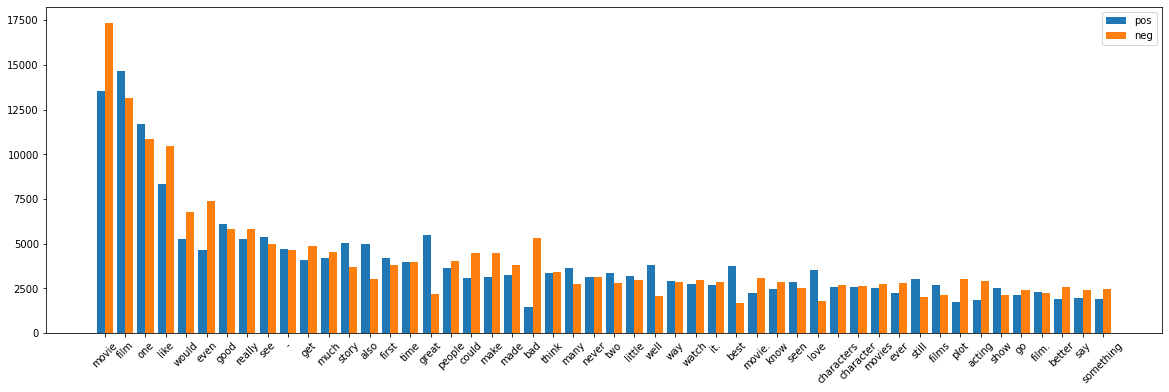

In [19]:
import matplotlib.pyplot as plt

combined_wf = get_word_frequency(df_train['text'].tolist())
top_words = sorted(combined_wf.items(), key=lambda x: x[1], reverse=True)[:50]
top_words = [x[0] for x in top_words]

pos_freqs = [pos_wf[word] for word in top_words]
neg_freqs = [neg_wf[word] for word in top_words]

xs = np.arange(len(top_words))
plt.figure(figsize=(20,6))
plt.bar(xs-0.2, pos_freqs, 0.4, label='pos')
plt.bar(xs+0.2, neg_freqs, 0.4, label='neg')
plt.xticks(xs, top_words, rotation=45)
plt.legend()

In [20]:
# TF-IDF : term frequency - inverse document frequency  -> text embeddings
# build a vocab: top 300 words
# for each sentence -> 300-dim vector, frequency for each 300 words
# once u have vector for a text -> algorithm (SVM, random forest, neural network)

In [21]:
import string
import re

def clean_and_tokenize(text):
    text = text.lower()                     # lowercase
    text = text.replace('<br />', '')       # remove line break token
    tokens = text.split()                   # split into words / whitespace tokenize
    tokens = [x for x in tokens if x not in en_stopwords]       # remove stopwords
    text = ' '.join(tokens)                 # combine tokens into a sentence
    for punc in string.punctuation:         # removing punctuations
        text = text.replace(punc, ' ')
    text = re.sub('\s+', ' ', text)         # > 1 whitespace -> 1 whitespace
    text = text.strip()
    tokens = text.split()
    tokens = [x for x in tokens if len(x) > 2]      # words > 2 characters
    return tokens

sample = df_train.sample(1).iloc[0,0]
tokens = clean_and_tokenize(sample)

print(sample)
print(tokens)

New York police detective Mark Dixon (Dana Andrews) is a guy who has to deal with his own demons on a daily basis at the same time as coping with the normal ups and downs of everyday life. The strain produced by his internal struggle and his intense hatred of criminals, leads him to make serious errors of judgement and to fail to recognise the need for any code of conduct to be adhered to in his dealings with people on the wrong side of the law. He has a track record of treating suspects and known criminals with gross brutality and this has brought him into conflict with his superior officers who have censured him for the amount of violence he has regularly used. Dixon cannot reconcile these calls for restraint with his own extreme and irrational hatred of all criminals. He is tormented by the fact that his father was a criminal and has been left with a powerful need to live down his father's reputation and to avoid fulfilling the low expectations that many people have of him as a cons

In [22]:
def get_wf_vector(tokens, vocab):
    word_to_idx = {word: i for i, word in enumerate(vocab)}
    wf = np.zeros(len(vocab))
    vocab_set = set(vocab)
    for token in tokens:
        if token in vocab_set:
            wf[word_to_idx[token]] += 1
    return wf

vocab = sorted(combined_wf.items(), key=lambda x: x[1], reverse=True)[:300]     # 300 most frequent words in the train set
vocab = [x[0] for x in vocab]

sample = df_train.sample(1).iloc[0,0]
tokens = clean_and_tokenize(sample)
vec = get_wf_vector(tokens, vocab)

print(sample)
print(tokens)
print(vec)

This film is really bad. It maybe harsh, but it is. It really is. Poor script, every vampire cliché in the book is used, and no sympathy is given at all to the origins of the main character ... i.e. ole Dracula. There have been some truly brilliant Dracula/vampire movies in the past, but this doesn't even make it into the "dire" slot.<br /><br />Take a selection of people who seem to have dropped out of a teen-slasher move, add a dribble of Dracula Lore and mix in a heady tonic of religious/surreal day-dreaming ... and you get a confusing mess of a film - Dracula 2000.<br /><br />I really cannot find any good things to say about this movie, as if it wasn't bad enough that it was made in the first place, they seem to have made Johnny Lee Miller effect an English accent ... Whats the problem with that I hear you cry ... Well, he is English, but he sounds like an American trying to do an English accent.<br /><br />All in all you may as well say your money (if you were thinking of buying i

In [23]:
from functools import partial

train_vecs = df_train['text'].apply(clean_and_tokenize).apply(partial(get_wf_vector, vocab=vocab))
val_vecs = df_val['text'].apply(clean_and_tokenize).apply(partial(get_wf_vector, vocab=vocab))

train_vecs = np.stack(train_vecs.tolist(), axis=0)
val_vecs = np.stack(val_vecs.tolist(), axis=0)

In [24]:
from sklearn.svm import SVC, SVR

# SVM is very slow. proportional dataset size^2
model = SVC()
model.fit(train_vecs, df_train['label'])

SVC()

In [25]:
preds = model.predict(val_vecs)
preds[:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
acc = (df_val['label'] == preds).sum() / len(df_val)
acc

0.80072

## Word vectors - Bag-of-Words model

In [27]:
# text -> list of tokens -> list of vectors -> sequence (sequence_size, vector_size)

def get_text_vector(tokens):
    vecs = [glove_vectors[token] for token in tokens if token in glove_vectors]
    return sum(vecs) / len(vecs)        # taking the average vector

sample = df_train.sample(1).iloc[0,0]
tokens = clean_and_tokenize(sample)
text_vector = get_text_vector(tokens)

print(sample)
print(tokens)
print(text_vector.shape)
text_vector                 # average of word vectors of all extracted tokens

I caught this movie on my local movie channel, and i rather enjoyed watching the film. It has all the elements of a good teen film, and more - this film, aside from dealing with boys-girls relationships and sex and the like, also deals with the issue of steroid use by young people.<br /><br />The film has that real-life feel to it - no loud music, no special effects and no outrageous scenes - which, for this movie, was right. That feel makes it easy to relate to the characters in the film - some of which we probably know from where we live.<br /><br />Overall, a good movie, fun to watch.<br /><br />8/10
['caught', 'movie', 'local', 'movie', 'channel', 'rather', 'enjoyed', 'watching', 'film', 'elements', 'good', 'teen', 'film', 'film', 'aside', 'dealing', 'boys', 'girls', 'relationships', 'sex', 'like', 'also', 'deals', 'issue', 'steroid', 'use', 'young', 'people', 'the', 'film', 'real', 'life', 'feel', 'loud', 'music', 'special', 'effects', 'outrageous', 'scenes', 'which', 'movie', 'ri

array([-7.35107288e-02,  1.64569527e-01, -4.12364118e-02,  5.53680696e-02,
       -1.09191522e-01,  8.97130147e-02,  5.00047982e-01, -2.00162339e-03,
       -7.12229684e-02, -1.48468643e-01, -9.02684964e-03, -1.08921662e-01,
       -6.61766946e-01,  1.69396214e-02,  8.45003407e-03, -3.53736319e-02,
       -8.05366877e-03,  1.07256271e-01,  2.24391632e-02,  9.91789773e-02,
       -9.24723297e-02,  2.00604517e-02,  3.91295273e-03,  1.32425278e-01,
       -6.24558888e-02,  8.51062596e-01, -1.09992273e-01,  2.48825122e-02,
        7.16955289e-02, -1.60576910e-01, -4.82636708e-04, -1.93548515e-01,
       -2.27218255e-01,  1.13573544e-01, -4.98432014e-03,  1.54931182e-02,
        6.04615696e-02, -6.29447252e-02,  1.53428540e-01,  1.40126256e-04,
        3.08455706e-01, -1.07050128e-01,  4.46765050e-02, -1.88099593e-01,
       -9.64855701e-02,  8.23851153e-02,  1.04020491e-01, -1.32754028e-01,
       -1.53179064e-01, -5.58382496e-02, -7.65355676e-02, -2.40036938e-02,
       -2.70911247e-01,  

In [28]:
# pre-compute
train_vecs = df_train['text'].apply(clean_and_tokenize).apply(get_text_vector)
val_vecs = df_val['text'].apply(clean_and_tokenize).apply(get_text_vector)

train_vecs = np.stack(train_vecs.tolist(), axis=0)
val_vecs = np.stack(val_vecs.tolist(), axis=0)

# transform on-the-fly -> more memory efficient (but incur processing time)

In [29]:
from sklearn.svm import SVC, SVR

# SVM is very slow. proportional dataset size^2
model = SVC()
model.fit(train_vecs, df_train['label'])

SVC()

In [30]:
preds = model.predict(val_vecs)
preds[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [31]:
acc = (df_val['label'] == preds).sum() / len(df_val)
acc

0.82636

In [32]:
misclassified = (df_val['label'] != preds)      # boolean array of examples that differ
sample = df_val[misclassified].sample(1).iloc[0]
print(sample[0])
print(clean_and_tokenize(sample[0]))
print(sample[1])

# drawbacks of the Bag-of-words model -> don't care about ordering of the words

How many movies are there that you can think of when you see a movie like this? I can't count them but it sure seemed like the movie makers were trying to give me a hint. I was reminded so often of other movies, it became a big distraction. One of the borrowed memorable lines came from a movie from 2003 - Day After Tomorrow. One line by itself, is not so bad but this movie borrows so much from so many movies it becomes a bad risk.<br /><br />BUT...<br /><br />See The Movie! Despite its downfalls there is enough to make it interesting and maybe make it appear clever. While borrowing so much from other movies it never goes overboard. In fact, you'll probably find yourself battening down the hatches and riding the storm out. Why? ...Costner and Kutcher played their characters very well. I have never been a fan of Kutcher's and I nearly gave up on him in The Guardian, but he surfaced in good fashion. Costner carries the movie swimmingly with the best of Costner's ability. I don't think Mrs

In [33]:
import torch
from torch import nn

def get_model(in_channels, num_channels):
    layers = []
    for i, out_channels in enumerate(num_channels[:-1]):
        layer = nn.Sequential(
            nn.Linear(in_channels, out_channels, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )
        layers.append(layer)
        in_channels = out_channels

    layers.append(nn.Linear(in_channels, num_channels[-1]))
    model = nn.Sequential(*layers)
    return model

model = get_model(200, [512, 512, 1])
model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Linear(in_features=512, out_features=1, bias=True)
)

In [35]:
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, vectors, labels):
        self.vectors = vectors
        self.labels = labels

    def __getitem__(self, idx):
        return self.vectors[idx], self.labels[idx]

    def __len__(self):
        return len(self.vectors)

train_ds = ReviewDataset(train_vecs, df_train['label'].tolist())
val_ds = ReviewDataset(val_vecs, df_val['label'].tolist())

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

vec, label = train_ds[13000]
print(vec.shape, label)

(200,) 0


In [36]:
from tqdm import tqdm
import torch.nn.functional as F

device = 'cuda'

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

n_epochs = 10

for i in range(n_epochs):
    print(f'Epoch{i}')
    pbar = tqdm(train_loader)
    for vecs, labels in pbar:
        logits = model(vecs.to(device)).squeeze()
        loss = F.binary_cross_entropy_with_logits(logits, labels.to(device).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f'Loss: {loss.item():.4f}')

Epoch0


Loss: 0.6691: 100%|██████████| 782/782 [00:06<00:00, 118.52it/s]


Epoch1


Loss: 0.2499: 100%|██████████| 782/782 [00:06<00:00, 122.70it/s]


Epoch2


Loss: 0.8196: 100%|██████████| 782/782 [00:06<00:00, 120.98it/s]


Epoch3


Loss: 0.1358: 100%|██████████| 782/782 [00:06<00:00, 121.31it/s]


Epoch4


Loss: 0.2240: 100%|██████████| 782/782 [00:06<00:00, 120.59it/s]


Epoch5


Loss: 0.4013: 100%|██████████| 782/782 [00:06<00:00, 120.24it/s]


Epoch6


Loss: 0.7565: 100%|██████████| 782/782 [00:06<00:00, 123.41it/s]


Epoch7


Loss: 0.1959: 100%|██████████| 782/782 [00:06<00:00, 122.33it/s]


Epoch8


Loss: 0.3118: 100%|██████████| 782/782 [00:06<00:00, 120.28it/s]


Epoch9


Loss: 0.4897: 100%|██████████| 782/782 [00:06<00:00, 121.59it/s]


In [37]:
model.eval()
preds = []

for vecs, _ in tqdm(val_loader):
    with torch.inference_mode():
        logits = model(vecs.to(device)).squeeze()
    preds.append(logits.cpu().numpy() >= 0)

preds = np.concatenate(preds, axis=0)
preds.shape

100%|██████████| 782/782 [00:00<00:00, 1180.37it/s]


(25000,)